In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/heart.csv')
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [2]:
# Replace '?' with NaN (if any)
df.replace('?', np.nan, inplace=True)

# Convert to numeric where possible
for col in df.columns:
    if df[col].dtype == 'object' and col != 'target':
        df[col] = pd.to_numeric(df[col], errors='ignore')

# Handle missing values
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols = [c for c in num_cols if c != 'target']
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

cat_cols = list(set(df.columns) - set(num_cols) - {'target'})
for c in cat_cols:
    if df[c].isnull().sum() > 0:
        df[c].fillna(df[c].mode()[0], inplace=True)

print("Missing values after cleaning:", df.isnull().sum().sum())


Missing values after cleaning: 0


**Split Fetures  and Target Encoding**

In [3]:
# Prepare features and target
X = df.drop('target', axis=1)
y = df['target']

# One-hot encode categorical columns (drop_first to avoid dummy trap)
categorical_cols = [c for c in X.columns if c in ['cp','restecg','slope','thal','ca','sex','fbs','exang'] and c in X.columns]
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric columns
scaler = StandardScaler()
numeric_cols = [c for c in X_encoded.columns if X_encoded[c].dtype != 'uint8']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


**Evaluation Function**

In [4]:
def evaluate_model(model, X_tr, X_te, y_tr, y_te, model_name):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:,1] if hasattr(model, 'predict_proba') else model.decision_function(X_te)

    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred)
    rec = recall_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)
    roc = roc_auc_score(y_te, y_proba)

    print(f"\n📊 {model_name} Results:")
    print("Accuracy:", round(acc,4))
    print("Precision:", round(prec,4))
    print("Recall:", round(rec,4))
    print("F1 Score:", round(f1,4))
    print("ROC AUC:", round(roc,4))
    print("\nClassification Report:\n", classification_report(y_te, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_te, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix — {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc:.3f})")
    plt.plot([0,1],[0,1],'--', color='grey')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


In [5]:
plt.show()


📊 Logistic Regression Results:
Accuracy: 0.8683
Precision: 0.8482
Recall: 0.9048
F1 Score: 0.8756
ROC AUC: 0.944

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86       100
           1       0.85      0.90      0.88       105

    accuracy                           0.87       205
   macro avg       0.87      0.87      0.87       205
weighted avg       0.87      0.87      0.87       205



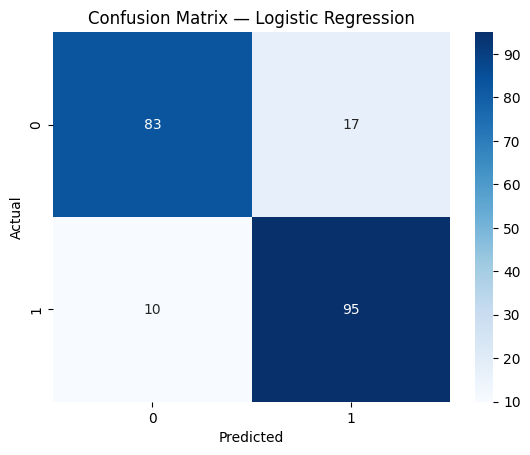

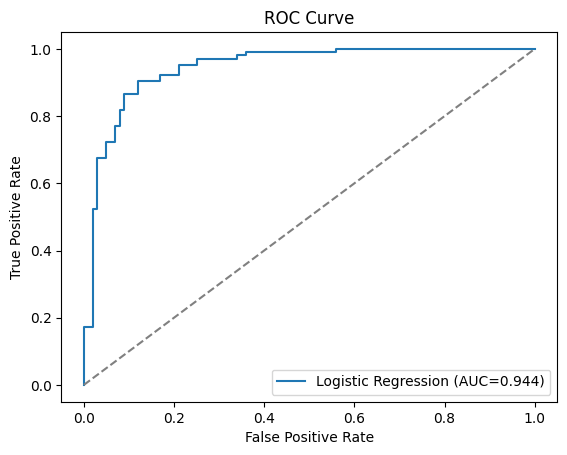

In [6]:
lr = LogisticRegression(max_iter=1000, random_state=42)
evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")



📊 Random Forest Results:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



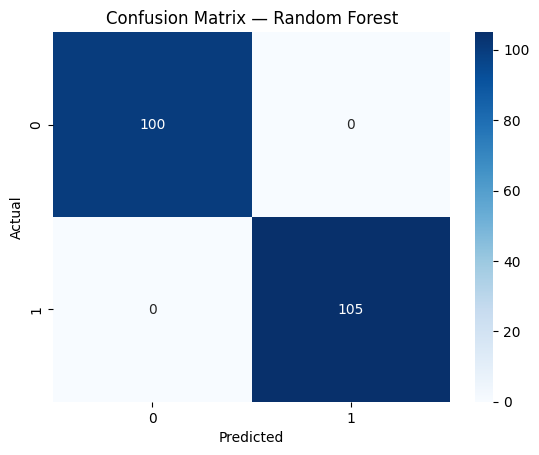

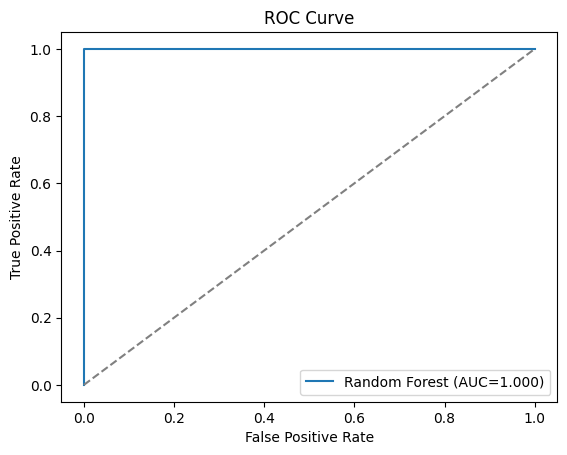

In [7]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")


**Feature Importance**

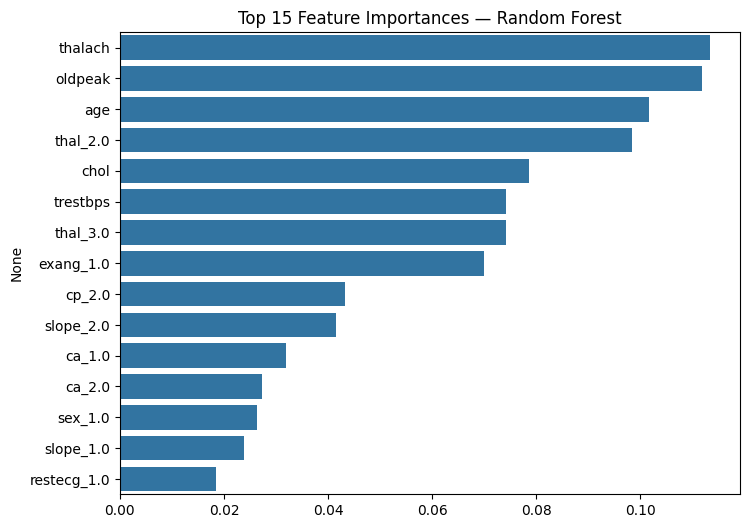

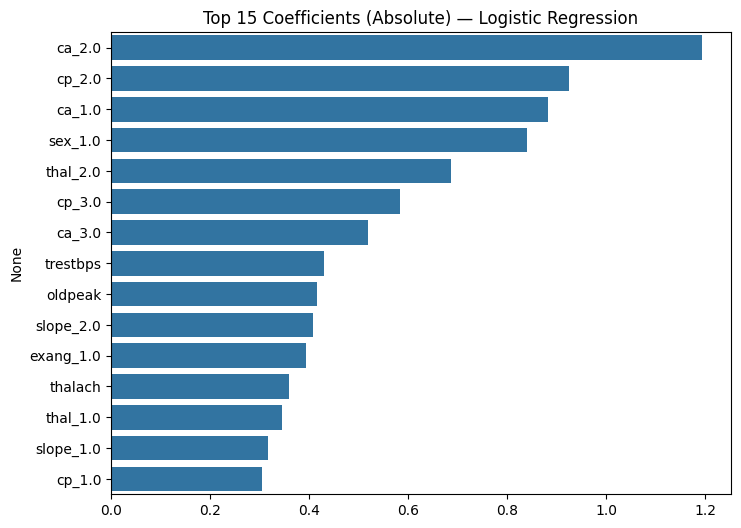

In [8]:
# Random Forest feature importance
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=importances.values[:15], y=importances.index[:15])
plt.title('Top 15 Feature Importances — Random Forest')
plt.show()

# Logistic Regression Coefficients
coef = pd.Series(np.abs(lr.coef_[0]), index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=coef.values[:15], y=coef.index[:15])
plt.title('Top 15 Coefficients (Absolute) — Logistic Regression')
plt.show()
